In [37]:
import pandas as pd
import yfinance as yf
import numpy as np
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [38]:
# Define the ticker symbol
tickerSymbol = 'QQQ'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2023-11-04')
tickerDf['Date'] = tickerDf.index.date

# See your data
print(tickerDf)

                                 Open        High         Low       Close  \
Date                                                                        
2010-01-04 00:00:00-05:00   40.810823   40.951763   40.757970   40.890099   
2010-01-05 00:00:00-05:00   40.863673   40.960570   40.661073   40.890099   
2010-01-06 00:00:00-05:00   40.872477   41.004605   40.581787   40.643448   
2010-01-07 00:00:00-05:00   40.705116   40.757969   40.449662   40.669880   
2010-01-08 00:00:00-05:00   40.581801   41.004620   40.458480   41.004620   
...                               ...         ...         ...         ...   
2023-10-30 00:00:00-04:00  347.829987  350.540009  346.450012  349.200012   
2023-10-31 00:00:00-04:00  349.230011  351.250000  346.619995  350.869995   
2023-11-01 00:00:00-04:00  351.720001  357.529999  351.619995  356.959991   
2023-11-02 00:00:00-04:00  361.540009  363.679993  360.299988  363.440002   
2023-11-03 00:00:00-04:00  364.750000  369.019989  364.519989  367.709991   

In [39]:
## transformation
tickerDf = tickerDf.drop(columns=['Dividends', 'Stock Splits', 'Open'])
tickerDf['Date'] = tickerDf.index.date



In [40]:
tickerDf['Date'] = tickerDf.index.date

# Reset the index to get a default integer index
tickerDf.reset_index(drop=True, inplace=True)

tickerDf = tickerDf[['Date', 'Close', 'Volume']]

tickerDf

,Date,Close,Volume
0,2010-01-04,40.890099,62822800
1,2010-01-05,40.890099,62935600
2,2010-01-06,40.643448,96033000
3,2010-01-07,40.669880,77094100
4,2010-01-08,41.004620,88886600
...,...,...,...
3479,2023-10-30,349.200012,55298500
3480,2023-10-31,350.869995,47671900
3481,2023-11-01,356.959991,58992700
3482,2023-11-02,363.440002,58162400


Calculate daily return

In [41]:
tickerDf['daily_return'] = tickerDf['Close'].pct_change()
tickerDf['state'] = np.where(tickerDf['daily_return'] >= 0, 'up', 'down')

In [42]:
tickerDf

,Date,Close,Volume,daily_return,state
0,2010-01-04,40.890099,62822800,NaN,down
1,2010-01-05,40.890099,62935600,0.000000,up
2,2010-01-06,40.643448,96033000,-0.006032,down
3,2010-01-07,40.669880,77094100,0.000650,up
4,2010-01-08,41.004620,88886600,0.008231,up
...,...,...,...,...,...
3479,2023-10-30,349.200012,55298500,0.011265,up
3480,2023-10-31,350.869995,47671900,0.004782,up
3481,2023-11-01,356.959991,58992700,0.017357,up
3482,2023-11-02,363.440002,58162400,0.018153,up


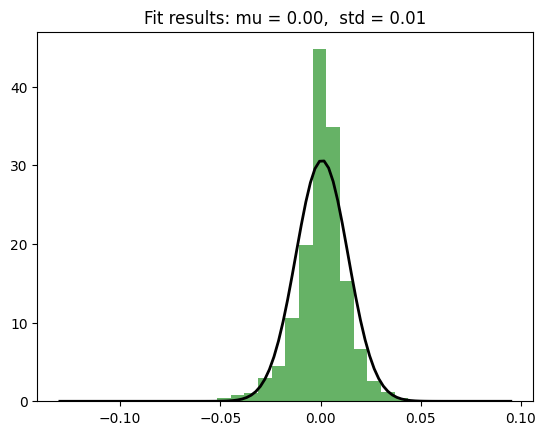

In [43]:
# Assume 'daily_return' is a Series or a single column DataFrame
returns = tickerDf['daily_return'].dropna()  # Remove NaN values for plotting

# Plot histogram
plt.hist(returns, bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF of the normal distribution using returns' mean and standard deviation
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, returns.mean(), returns.std())
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mu = %.2f,  std = %.2f" % (returns.mean(), returns.std())
plt.title(title)

plt.show()


In [44]:
transition_matrix = pd.crosstab(tickerDf['state'], tickerDf['state'].shift(-1), normalize='index')

print(transition_matrix)

state      down        up
state                    
down   0.435831  0.564169
up     0.444045  0.555955


In [45]:
# Define the model
n_components = 2  # for example, 'volatile' and 'stable'

# Initialize the HMM
model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)

# Prepare the data (the observed sequence of daily returns)
returns = tickerDf['daily_return'].dropna().values
returns = returns.reshape(-1, 1)  # hmmlearn expects a 2D array

# Train the HMM
model.fit(returns)

# Predict the hidden states
hidden_states = model.predict(returns)

Model is not converging.  Current: 10706.358801537937 is not greater than 10706.55744411713. Delta is -0.1986425791928923


In [46]:
# Prepare the data (the observed sequence of daily returns)
returns = tickerDf['daily_return'].dropna().values
returns = returns.reshape(-1, 1)  # hmmlearn expects a 2D array

# Predict the hidden states for the entire series
hidden_states = model.predict(returns)

# Infer the direction for each day based on the model's predictions
predicted_directions = []
for i in range(len(hidden_states)-1):  # exclude the last day since there's no next day to predict
    current_state = hidden_states[i]
    next_state_probs = model.transmat_[current_state]
    next_state = np.argmax(next_state_probs)
    predicted_mean_return = model.means_[next_state][0]
    predicted_directions.append('up' if predicted_mean_return > 0 else 'down')

# Append the last day's prediction
# This prediction assumes the same state as the last known state since there's no future data
predicted_directions.append('up' if model.means_[hidden_states[-1]][0] > 0 else 'down')

# Insert the predicted directions into the DataFrame
tickerDf['predicted_direction'] = ['up'] + predicted_directions  # add 'up' as a placeholder for the first day

# Now, calculate the accuracy
tickerDf['actual_next_day_direction'] = np.where(tickerDf['daily_return'].shift(-1) >= 0, 'up', 'down')
tickerDf = tickerDf[:-1]  # Remove the last row as there's no actual next day to compare

# Calculate the accuracy
accuracy = np.mean(tickerDf['predicted_direction'] == tickerDf['actual_next_day_direction'])
print(f"Prediction accuracy: {accuracy:.2%}")

# Print the DataFrame to see the actual vs predicted
print(tickerDf[['Date', 'daily_return', 'actual_next_day_direction', 'predicted_direction']])


Prediction accuracy: 55.87%
            Date  daily_return actual_next_day_direction predicted_direction
0     2010-01-04           NaN                        up                  up
1     2010-01-05      0.000000                      down                  up
2     2010-01-06     -0.006032                        up                  up
3     2010-01-07      0.000650                        up                  up
4     2010-01-08      0.008231                      down                  up
...          ...           ...                       ...                 ...
3478  2023-10-27      0.004801                        up                  up
3479  2023-10-30      0.011265                        up                  up
3480  2023-10-31      0.004782                        up                  up
3481  2023-11-01      0.017357                        up                  up
3482  2023-11-02      0.018153                        up                  up

[3483 rows x 4 columns]


Prediction

In [47]:
class HiddenMarkovModelPredictor:
    def __init__(self, n_components, n_iter=1000):
        self.model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=n_iter)

    def fit(self, data):
        dropna_data =  data[~np.isnan(data)]
        reshaped_data = dropna_data.reshape(-1, 1)
        self.model.fit(reshaped_data)

    def predict(self, data):
        reshaped_data = data.reshape(-1, 1)
        return self.model.predict(reshaped_data)
    
    def predict_next_hidden_state(self, last_data_point):
        reshaped_data = last_data_point.reshape(1, -1)
        _, next_hidden_state = self.model.decode(reshaped_data)
        return next_hidden_state[-1]  # Return the last state in the sequence

    def predict_next_price(self, last_price, last_pct_chg):
        next_hidden_state = self.predict_next_hidden_state(last_pct_chg)
        next_pct_chg = self.model.means_[next_hidden_state]
        next_price = last_price * (1 + next_pct_chg)
        return next_price
    
    def predict_next_state_probs(self, last_observed_data):
        reshaped_data = last_observed_data.reshape(-1, 1)
        _, current_state = self.model.decode(reshaped_data)
        next_state_probs = self.model.transmat_[current_state[-1], :]
        return next_state_probs
    
    
    def predict_direction(self, last_data_point):
        next_hidden_state = self.predict_next_hidden_state(last_data_point)
        predicted_mean_return = self.model.means_[next_hidden_state][0]
        direction = 'up' if predicted_mean_return > 0 else 'down'
        return direction


In [48]:
# Initialize the HMM predictor
hmm_predictor = HiddenMarkovModelPredictor(n_components=2)
hmm_predictor.fit(tickerDf['daily_return'].dropna().values)

# Assume you want to predict the next state given the last data point
last_data_point = tickerDf['daily_return'].iloc[-1]
next_state_probs = hmm_predictor.predict_next_state_probs(np.array([last_data_point]))

# Predict the next price given the last price and the last percentage change
last_price = tickerDf['Close'].iloc[-1]
predicted_next_price = hmm_predictor.predict_next_price(last_price, last_data_point)

print(f"The predicted next price is: {predicted_next_price}")

# Assuming you have the last observed daily return and the last observed price
last_pct_chg = tickerDf['daily_return'].iloc[-1]
last_price = tickerDf['Close'].iloc[-1]

# Initialize the HMM predictor
hmm_predictor = HiddenMarkovModelPredictor(n_components=2)
hmm_predictor.fit(tickerDf['daily_return'].dropna().values)

# Predict the direction
predicted_direction = hmm_predictor.predict_direction(last_pct_chg)

print(f"The model predicts a {predicted_direction} day for the next trading session.")


Model is not converging.  Current: 10703.887897739027 is not greater than 10704.043416504792. Delta is -0.15551876576500945
Model is not converging.  Current: 10701.916120087646 is not greater than 10701.945727245542. Delta is -0.029607157895952696


The predicted next price is: [363.91773177]
The model predicts a up day for the next trading session.
